# Difftest Results

Connect to results database:

In [8]:
import sqlalchemy as sql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FuncFormatter
from collections import OrderedDict
from labm8 import viz

%matplotlib inline
sns.set(style="ticks", color_codes=True)
plt.style.use(["seaborn-white", "seaborn-paper"])

import db
from db import *
%run util.py

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

## Overview

In [10]:
import pandas as pd
from collections import OrderedDict

def get_device_stats(s, tables, testbed_id, no_opt):
    print(f"\r\033[1Kfetching {tables.name} {testbed_id} {no_opt} ...", end="")
    q = results_in_order(s, tables, testbed_id, no_opt, tables.results.id, tables.meta.cumtime, reverse=True)

    num_results = results_in_order(s, tables, testbed_id, no_opt, sql.sql.func.count(tables.results.id)).scalar()
    if num_results:
        _, total_time = q.first()
    else:
        total_time = 0

    return num_results, total_time


def get_device_overview(s, testbed_id):
    testbed = s.query(Testbed).filter(Testbed.id == testbed_id).first()
    
    clsmith_noopt_results, clsmith_noopt_time = get_device_stats(s, CLSMITH_TABLES, testbed_id, True)
    clsmith_results, clsmith_time = get_device_stats(s, CLSMITH_TABLES, testbed_id, False)

    clgen_noopt_results, clgen_noopt_time = get_device_stats(s, CLGEN_TABLES, testbed_id, True)
    clgen_results, clgen_time = get_device_stats(s, CLGEN_TABLES, testbed_id, False)
    
    r1 = OrderedDict()
    r1["Device"] = device_str(testbed.device)
    r1["±"] = "-"
    r1["CLSmith time"] = clsmith_noopt_time
    r1["CLSmith time (hrs)"] = "{:.1f}h".format(clsmith_noopt_time / 3600)
    r1["CLSmith results"] = clsmith_noopt_results
    r1["CLgen time"] = clgen_noopt_time
    r1["CLgen time (hrs)"] = "{:.1f}h".format(clgen_noopt_time / 3600)
    r1["CLgen results"] = clgen_noopt_results
    
    r2 = OrderedDict()
    r2["Device"] = device_str(testbed.device)
    r2["±"] = "+"
    r2["CLSmith time"] = clsmith_time
    r2["CLSmith time (hrs)"] = "{:.1f}h".format(clsmith_time / 3600)
    r2["CLSmith results"] = clsmith_results
    r2["CLgen time"] = clgen_time
    r2["CLgen time (hrs)"] = "{:.1f}h".format(clgen_time / 3600)
    r2["CLgen results"] = clgen_results
    
    return r1, r2


rows = []
with Session(commit=False) as s:
    for config_id, testbed_id in CONFIGURATIONS:
        rows += get_device_overview(s, testbed_id)
overview_table = pd.DataFrame(rows)
overview_table

fetching CLgen 11 False .....

,Device,±,CLSmith time,CLSmith time (hrs),CLSmith results,CLgen time,CLgen time (hrs),CLgen results
0,GeForce GTX 1080,-,447238.0,124.2h,21000,237623.0,66.0h,80277
1,GeForce GTX 1080,+,481269.0,133.7h,21000,219161.0,60.9h,72537
2,GeForce GTX 780,-,354007.0,98.3h,21000,147204.0,40.9h,75612
3,GeForce GTX 780,+,379922.0,105.5h,21000,77858.9,21.6h,37351
4,Intel HD Haswell GT2,-,372393.0,103.4h,7957,113507.0,31.5h,95810
5,Intel HD Haswell GT2,+,769054.0,213.6h,16087,114416.0,31.8h,95810
6,Intel E5-2620 v4,-,400025.0,111.1h,21000,113104.0,31.4h,67651
7,Intel E5-2620 v4,+,368823.0,102.5h,21000,101362.0,28.2h,61474
8,Intel E5-2650 v2,-,400860.0,111.3h,21001,110168.0,30.6h,56530
9,Intel E5-2650 v2,+,481302.0,133.7h,21000,105585.0,29.3h,55430


## Schedule

In [13]:
TIME_LIMIT = 48 * 3600

schedule = []
for _, row in overview_table.iterrows():
    for source in ["CLSmith", "CLgen"]:
        if row[f"{source} time"] < TIME_LIMIT:
            d = OrderedDict()
            d["Device"] = row["Device"]
            d["±"] = row["±"]
            d["Job"] = source
            d["Remaining time"] = (TIME_LIMIT - row[f"{source} time"])
            d["Remaining time (hours)"] = "{:.1f}h".format((TIME_LIMIT - row[f"{source} time"]) / 3600)
            schedule.append(d)
    
schedule = pd.DataFrame(schedule)
schedule.sort_values(by="Remaining time", ascending=False)

,Device,±,Job,Remaining time,Remaining time (hours)
1,GeForce GTX 780,+,CLgen,94941.1,26.4h
5,Intel E5-2620 v4,+,CLgen,71438.0,19.8h
12,ComputeAorta (Intel E5-2620),-,CLSmith,70303.0,19.5h
7,Intel E5-2650 v2,+,CLgen,67215.0,18.7h
6,Intel E5-2650 v2,-,CLgen,62632.0,17.4h
4,Intel E5-2620 v4,-,CLgen,59696.0,16.6h
2,Intel HD Haswell GT2,-,CLgen,59293.0,16.5h
3,Intel HD Haswell GT2,+,CLgen,58384.0,16.2h
9,Intel i5-4570,+,CLgen,51830.0,14.4h
8,Intel i5-4570,-,CLgen,50191.0,13.9h


## Testing Time

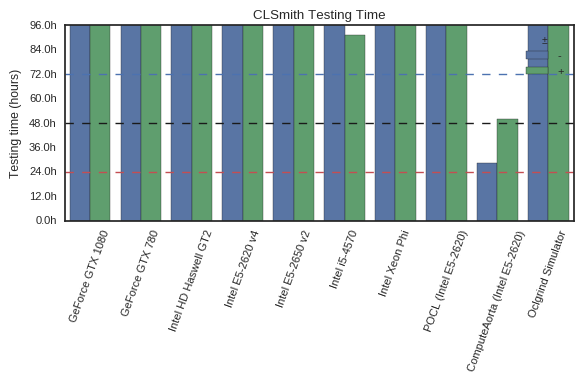

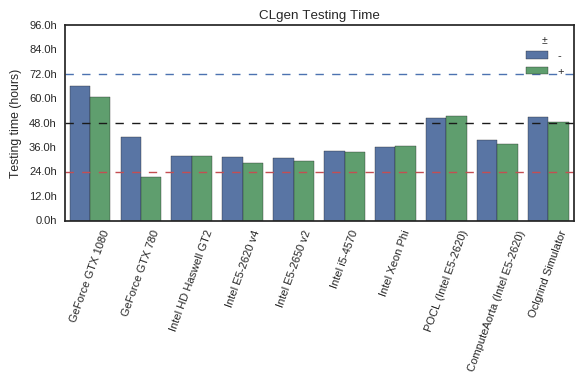

In [14]:
plt.style.use(["seaborn-white", "seaborn-paper"])

def plot_testing_time(table, time_column, title):
    sns.barplot(x="Device", y=time_column, data=overview_table, hue="±")

    ax = plt.gca()

    # X axis
    plt.setp(ax.get_xticklabels(), rotation=70)  # rotate x ticks
    ax.set_xlabel("")

    # Y axis
    ax.set_ylim((0, 96 * 3600))
    plt.yticks(np.arange(0, 100 * 3600, 12 * 3600))
    ax.yaxis.set_major_formatter(FuncFormatter(
        lambda x, pos: "{:.1f}h".format(x / 3600)))
    ax.set_ylabel("Testing time (hours)")
    plt.title(title)

    plt.axhline(y=24 * 3600, color="r", lw=1, linestyle="--")
    plt.axhline(y=48 * 3600, color="k", lw=1, linestyle="--")
    plt.axhline(y=72 * 3600, color="b", lw=1, linestyle="--")

    viz.finalise(figsize=(6, 4))

plot_testing_time(overview_table, "CLSmith time", "CLSmith Testing Time")
plot_testing_time(overview_table, "CLgen time", "CLgen Testing Time")

## Number of Results

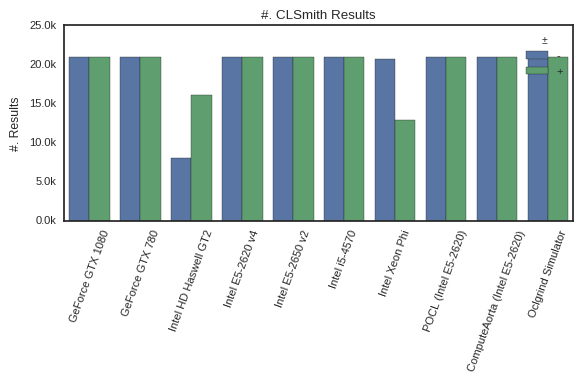

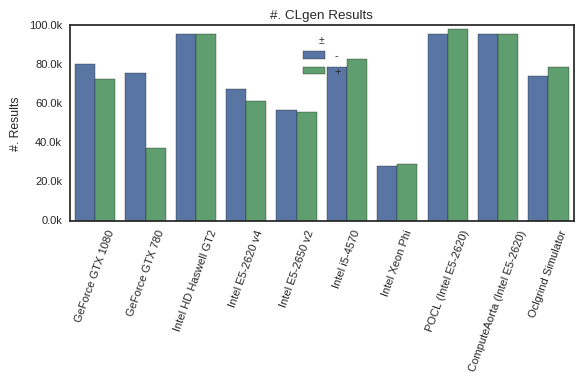

In [15]:
plt.style.use(["seaborn-white", "seaborn-paper"])

def plot_num_results(table, time_column, title):
    sns.barplot(x="Device", y=time_column, data=overview_table, hue="±")

    ax = plt.gca()

    # X axis
    plt.setp(ax.get_xticklabels(), rotation=70)  # rotate x ticks
    ax.set_xlabel("")

    # Y axis
    ax.yaxis.set_major_formatter(FuncFormatter(
        lambda x, pos: "{:.1f}k".format(x / 1000)))
    ax.set_ylabel("#. Results")
    plt.title(title)

    viz.finalise(figsize=(6, 4))

plot_num_results(overview_table, "CLSmith results", "#. CLSmith Results")
plot_num_results(overview_table, "CLgen results", "#. CLgen Results")

## Testbeds

In [16]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase

import os
from collections import OrderedDict


def get_platform_stats(s, testbed: Testbed):
    clgen_submitted = s.query(sql.sql.func.count(CLgenResult.submitted))\
        .filter(CLgenResult.testbed_id == testbed.id).scalar() or 0
    submitable_results = [coCLgenResult, cl_launcherCLgenResult]
    def get_submitted(table):
        """ submitted, non-duplicate bugs """
        return s.query(table)\
            .filter(table.testbed_id == testbed.id,
                    table.submitted == 1,
                    table.dupe != 1).count()

    # Total time running CLgen tests:
    clgen_time = sum(overview_table.loc[overview_table["Device"] == device_str(testbed.device)]["CLgen time"].values)
    # print(device_str(testbed.device), "CLgen", clgen_time)
    
    # Total time running CLgen reductions:
    reduction_time = s.query(sql.sql.func.sum(CLgenReduction.runtime)).join(CLgenResult)\
        .filter(CLgenResult.testbed_id == testbed.id).scalar() or 0
    # print(device_str(testbed.device), "reduction", reduction_time)
    
    # Total time from unstructured testing results:
    def get_runtime(table):
        return s.query(sql.sql.func.sum(table.runtime)).filter(table.testbed_id == testbed.id).scalar() or 0
    other_runtimes = sum(get_runtime(table) for table in [coCLgenResult, cl_launcherCLgenResult])
    # print(device_str(testbed.device), "other", other_runtimes)

    return (
        clgen_time + reduction_time + other_runtimes,
        clgen_submitted + sum(get_submitted(table) for table in submitable_results),
    )


def get_row(s, config_id, testbed_id):
    testbed = s.query(Testbed).filter(Testbed.id == testbed_id).first()
    d = OrderedDict()
    d["#."] = config_id
    d["Platform"] = platform_str(testbed.platform)
    d["Device"] = device_str(testbed.device)
    d["Driver"] = driver_str(testbed.driver)
    d["OpenCL"] = testbed.opencl
    d["Operating system"] = host_str(testbed.host)
    d["Device type"] = devtype_str(testbed.devtype)
    runtime, submitted = get_platform_stats(s, testbed)
    d["Testing time"] = "{:.0f} hours".format(round(runtime / 3600))
    d["B.R. Submitted"] = submitted
    return d

with Session(commit=False) as s:
    rows = [get_row(s, *x) for x in CONFIGURATIONS]
table = pd.DataFrame(rows)
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/platforms.tex"), "w") as outfile:
    print(f"""\
\\begin{{tabular}}{{ cllllll | rr }}
\\toprule
\\textbf{{\\#. }} & \\textbf{{Platform}} & \\textbf{{Device}} & \\textbf{{Driver}} & \\textbf{{OpenCL}} & 
\\textbf{{Operating system}} & \\textbf{{Device Type}} & \\textbf{{Testing time}} & \\textbf{{Bugs Submitted}} \\\\
\\midrule""", file=outfile)
    for row in rows:
        print(" & ".join([str(x) for x in row.values()]), "\\\\", file=outfile)
    print(f"""
\\bottomrule
\\end{{tabular}}
""", file=outfile)

!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/platforms.tex" && git push
table

Current branch master is up to date.
GeForce GTX 1080 CLgen 456784.0
GeForce GTX 1080 reduction 0
GeForce GTX 1080 other 25334.61571907997
GeForce GTX 780 CLgen 225062.9
GeForce GTX 780 reduction 0
GeForce GTX 780 other 0
Intel HD Haswell GT2 CLgen 227923.0
Intel HD Haswell GT2 reduction 0
Intel HD Haswell GT2 other 1786.055373430252
Intel E5-2620 v4 CLgen 214466.0
Intel E5-2620 v4 reduction 0
Intel E5-2620 v4 other 19788.171939373016
Intel E5-2650 v2 CLgen 215753.0
Intel E5-2650 v2 reduction 0
Intel E5-2650 v2 other 20230.333275556564
Intel i5-4570 CLgen 243579.0
Intel i5-4570 reduction 0
Intel i5-4570 other 3855.1008055210114
Intel Xeon Phi CLgen 260649.0
Intel Xeon Phi reduction 0
Intel Xeon Phi other 23843.072967529297
POCL (Intel E5-2620) CLgen 365913.0
POCL (Intel E5-2620) reduction 0
POCL (Intel E5-2620) other 17597.073311805725
ComputeAorta (Intel E5-2620) CLgen 279153.0
ComputeAorta (Intel E5-2620) reduction 0
ComputeAorta (Intel E5-2620) other 0
Oclgrind Simulator CLgen 35831

,#.,Platform,Device,Driver,OpenCL,Operating system,Device type,Testing time,B.R. Submitted
0,1,NVIDIA CUDA,GeForce GTX 1080,375.39,1.2,Ubuntu 16.04 64bit,GPU,134 hours,0
1,2,NVIDIA CUDA,GeForce GTX 780,361.42,1.2,openSUSE 13.1 64bit,GPU,63 hours,0
2,3,Intel Gen OCL Driver,Intel HD Haswell GT2,1.3,1.2,Ubuntu 16.04 64bit,GPU,64 hours,0
3,4,Intel OpenCL,Intel E5-2620 v4,1.2.0.25,2.0,Ubuntu 16.04 64bit,CPU,65 hours,0
4,5,Intel OpenCL,Intel E5-2650 v2,1.2.0.44,1.2,CentOS 7.1 64bit,CPU,66 hours,0
5,6,Intel OpenCL,Intel i5-4570,1.2.0.25,1.2,Ubuntu 16.04 64bit,CPU,69 hours,0
6,7,Intel OpenCL,Intel Xeon Phi,1.2,1.2,CentOS 7.1 64bit,Accelerator,79 hours,0
7,8,POCL,POCL (Intel E5-2620),0.14,2.0,Ubuntu 16.04 64bit,CPU,107 hours,0
8,9,ComputeAorta,ComputeAorta (Intel E5-2620),1.14,1.2,Ubuntu 16.04 64bit,CPU,78 hours,0
9,10,Oclgrind,Oclgrind Simulator,16.10,1.2,Ubuntu 16.04 64bit,Emulator,104 hours,0


In [ ]:
%run mkmegatable.ipy

Current branch master is up to date.
Generating outcomes table ...


## Runtimes

In [ ]:
def get_runtimes():
    TIMEOUT = 60

    with Session(commit=False) as s:
        # CLSmith times
        q = s.query(
                CLSmithResult.runtime, 
                CLSmithProgram.runtime, 
                sql.sql.func.ifnull(CLSmithReduction.runtime, 0))\
            .join(CLSmithMeta)\
            .join(CLSmithProgram)\
            .outerjoin(CLSmithReduction)\
            .filter(CLSmithResult.classification != None,
                    CLSmithMeta.cumtime < TIME_LIMIT)
        clsmith_times = np.array([row for row in q])

        # CLgen times
        q = s.query(
                CLgenResult.runtime,
                CLgenProgram.runtime + CLgenHarness.generation_time,
                sql.sql.func.ifnull(CLgenReduction.runtime, 0))\
            .join(CLgenMeta)\
            .join(CLgenProgram)\
            .join(CLgenHarness)\
            .outerjoin(CLgenReduction)\
            .filter(CLgenResult.classification != None,
                    CLSmithMeta.cumtime < TIME_LIMIT)
        clgen_times = np.array([row for row in q])


    table = (
        [("Execution", x, "CLSmith") for x in clsmith_times[:,0] if x < TIMEOUT] +
        [("Generation", x, "CLSmith") for x in clsmith_times[:,1] if x < TIMEOUT] +
        [("Reduction", x, "CLSmith") for x in clsmith_times[:,2] if x > 0] +
        [("Execution", x, "CLgen") for x in clgen_times[:,0] if x < TIMEOUT] +
        [("Generation", x, "CLgen") for x in clgen_times[:,1] if x < TIMEOUT] +
        [("Reduction", x, "CLgen") for x in clgen_times[:,2] if x > 0])
    table = pd.DataFrame(table, columns=["Name", "Runtime (s)", "Source"])
    return table

runtimes_table = get_runtimes()

In [ ]:
sns.set(style="ticks")

def plot_runtimes(runtimes_table, *args, **kwargs):
    # Plot
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Name", y="Runtime (s)", hue="Source", data=runtimes_table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["Generation", "Execution", "Reduction"])

    
    # Y axis
    ax.set_yscale("log", nonposy='clip')
    plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
    
    # Border
    sns.despine(ax=ax)

    viz.finalise(*args, **kwargs)


plot_runtimes(runtimes_table, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_runtimes(runtimes_table, fs.path("~/docs/paper-project_b/build/img/runtimes.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/runtimes.pdf" && git push

## Kernel sizes

In [ ]:
def get_kernel_sizes():    
    with Session(commit=False) as s:
        # CLSmith times
        clsmith = s.query(CLSmithResult.classification, CLSmithProgram.src)\
            .join(CLSmithProgram)\
            .filter(CLSmithResult.classification != None,
                    CLSmithResult.classification != "pass")
        clsmith_bc = s.query(CLSmithResult.classification, CLSmithProgram.src)\
            .join(CLSmithProgram)\
            .filter(CLSmithResult.outcome == "bc")

        clgen = s.query(CLgenResult.classification, CLgenProgram.src)\
            .join(CLgenProgram)\
            .filter(CLgenResult.classification != None,
                    CLgenResult.classification != "pass")
        clgen_bc = s.query(CLgenResult.classification, CLgenProgram.src)\
            .join(CLgenProgram)\
            .filter(CLgenResult.outcome == "bc")
    
    table = (
        [(classification, len(src.split('\n')), "CLSmith") for classification, src in clsmith] +
        [("bc", len(src.split('\n')), "CLSmith") for _, src in clsmith_bc] +
        [(classification, len(src.split('\n')), "CLgen") for classification, src in clgen] +
        [("bc", len(src.split('\n')), "CLgen") for _, src in clgen_bc])
    
    return pd.DataFrame(table, columns=['Classification', 'Line count', 'Source'])

kernel_sizes_table = get_kernel_sizes()

In [ ]:
def plot_kernel_sizes(table, *args, **kwargs):
    sns.set(style="ticks")
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Classification", y="Line count", hue="Source", data=table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["w", "bf", "to"])

    # Y axis
    ax.set_yscale("log", nonposy='clip')
    # plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
    
    # Border
    sns.despine(ax=ax)
    
    viz.finalise(*args, **kwargs)
    
plot_kernel_sizes(kernel_sizes_table, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_kernel_sizes(kernel_sizes_table, fs.path("~/docs/paper-project_b/build/img/kernel-sizes.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/kernel-sizes.pdf" && git push

## Total time

In [ ]:
def get_totaltimes():
    
    def _t(s, results_table, programs_table, reductions_table):
        generation_time = sql.sql.func.ifnull(programs_table.runtime, clgen_generation_time)
        runtime = results_table.runtime
        reduction_time = sql.sql.func.ifnull(reductions_table.runtime, 0)
        total_time = generation_time + runtime + reduction_time

        q = s.query(total_time)\
            .outerjoin(programs_table)\
            .outerjoin(reductions_table)\
            .filter(results_table.classification != None)\
            .order_by(results_table.date)

        times = np.array([row[0] / 3600 for row in q]).cumsum()
        return times
    
    with Session(commit=False) as s:
        clsmith_times = _t(s, CLSmithResult, CLSmithProgram, CLSmithReduction)
        clgen_times = _t(s, CLgenResult, CLgenProgram, CLgenReduction)

    return clsmith_times, clgen_times

clsmith_times, clgen_times = get_totaltimes()

In [ ]:
def plot_total_tests(clsmith_times, clgen_times, *args, **kwargs):
    
    def thousands(x, pos):
        return "{:.0f}k".format(x / 1000)
    
    ax = plt.gca()
    ax.plot(clsmith_times, range(len(clsmith_times)), label="CLSmith")
    ax.plot(clgen_times, range(len(clgen_times)), label="CLgen")

    ax.set_xlabel("Testing time (hours)")
    ax.set_ylabel("Completed Test cases")
    
    # X axis
    ax.set_xlim((0, 48))
    
    # Y axis
    formatter = FuncFormatter(thousands)
    ax.set_ylim((0, 100000))
    ax.yaxis.set_major_formatter(formatter)
    
    ax.legend()
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
        
    viz.finalise(*args, **kwargs)

plot_total_tests(clsmith_times, clgen_times, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_total_tests(clsmith_times, clgen_times, fs.path("~/docs/paper-project_b/build/img/total-tests.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/total-tests.pdf" && git push